In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
n,m = x_train.shape
classes = y_train.max()+1
n_hidden = 50

#### Exercise 1

**Create a simple Model inherited from `nn.Module` with 3 Layers**

In [6]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super().__init__()
        ### Initialize Layers Here
        
    def __call__(self, x):
        pass
        

In [7]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_input,n_hidden), nn.ReLU(), nn.Linear(n_hidden,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [8]:
model = Model(m, n_hidden, 10)

In [9]:
pred = model(x_train)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

$$\log (\hbox{softmax(x)}_{i}) = \log(\frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}) $$


#### Exercise 2
**Create a function which calculates the log of softmax using Pytorch's Tensor**

In [10]:
def log_softmax(x): 
    pass

In [11]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [12]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [13]:
y_train[:3]

tensor([5, 0, 4])

In [14]:
sm_pred[0][5]

tensor(-2.2688, grad_fn=<SelectBackward>)

In [15]:
sm_pred[[0, 1, 2], [5,0,4]]

tensor([-2.2688, -2.3312, -2.4255], grad_fn=<IndexBackward>)

In [16]:
y_train.shape[0]

50000

### *Negative Log Likelihood*

We have 50000 output prediction tensors, with 10 columns each. For each input `i` and class `j`, we have $-\sum_{j}\log(p(x_{i,j})) == -\log(p(x_{k}))$ where `k` is the index of the correct class. That is the cross entropy loss for the prediction `i`. The mean of all data points is the _Negative Log Likelihood_

#### Exercise 3
**Calculate the _Negative Log Likelihood_**

In [17]:
def nll(prediction, target): 
    pass

In [18]:
def nll(prediction, target): 
    return -prediction[range(target.shape[0]), target].mean()

In [19]:
loss = nll(sm_pred, y_train)

In [20]:
loss

tensor(2.3050, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

#### Exercise 4
**Calculate the log softmax in a simplified manner**

In [21]:
def log_softmax(x): 
    pass

In [22]:
def log_softmax(x): 
    return x - x.exp().sum(-1,keepdim=True).log()

In [23]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

#### Exercise 5 
**Calculate the log softmax using the Exponential trick above**

In [24]:
def logsumexp(x):
    pass

In [25]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [26]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [27]:
def log_softmax(x): 
    return x - x.logsumexp(-1,keepdim=True)

In [28]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [29]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [30]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [31]:
loss_func = F.cross_entropy

In [32]:
#export
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [33]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.1170, -0.0057,  0.0758,  0.0108, -0.1090,  0.0218,  0.0513, -0.1365,
          0.1350, -0.0849], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [34]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3233, grad_fn=<NllLossBackward>)

In [35]:
accuracy(preds, yb)

tensor(0.0938)

In [36]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

#### Exercise 6
**Complete the training loop below**

In [38]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        # get the batch
        xb = None
        yb = None
        # get the output of the model on a batch of inputs
        pred = None
        # compare the output to the labels we have and compute a loss
        loss = None
        # calculate the gradients of the loss with respect to every parameter of the model

        # update said parameters with those gradients to make them a little bit better        
        with torch.no_grad():
            pass
            # Iterate through the model layers
                
                # check if the layer is subjected to update (i.e. is a parameter)
                
                    # update said parameters with those gradients and zero the gradient

            
                    

In [39]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [40]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1958, grad_fn=<NllLossBackward>), tensor(0.9375))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [41]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super().__init__()
        self.l1 = pass
        self.l2 = pass
        
    def __call__(self, x): 
        pass

SyntaxError: invalid syntax (<ipython-input-41-974b3a33918e>, line 4)

In [42]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_input,n_hidden)
        self.l2 = nn.Linear(n_hidden,n_out)
        
    def __call__(self, x):
        output = self.l1(x)
        output = F.relu(output)
        return self.l2(output)
        # shorter: return self.l2(F.relu(self.l1(x)))

In [43]:
model = Model(m, n_hidden, 10)

In [44]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [45]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [46]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

Instead of iterating through the model layers and checking if the layers is a parameter to be updated, Pytorch has the iterable `model.parameters()` which only keep the layers which have weights.

#### Exercise 7
Implement the same basic training loop but this time iterating directly through the parameters in the update loop

In [47]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            # get the batch
            xb = None
            yb = None
            # get the output of the model on a batch of inputs
            pred = None
            # compare the output to the labels we have and compute a loss
            loss = None
            # calculate the gradients of the loss with respect to every parameter of the model

            # update said parameters with those gradients to make them a little bit better        
            with torch.no_grad():
                # Iterate through the parameters

                    # update the parameters with those gradients and zero the gradient fo the model

SyntaxError: unexpected EOF while parsing (<ipython-input-47-bf873bd1a923>, line 19)

In [48]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [49]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1429, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [50]:
class DummyModule():
    def __init__(self, n_in, n_hidden, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,n_hidden)
        self.l2 = nn.Linear(n_hidden,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [51]:
mdl = DummyModule(m,n_hidden,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [52]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules using `self.add_module(name, module)`

In [53]:
layers = [nn.Linear(m,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10)]

In [54]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [55]:
model = Model(layers)

In [56]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [57]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [58]:
model = SequentialModel(layers)

In [59]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [60]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1654, grad_fn=<NllLossBackward>), tensor(0.9375))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [61]:
model = nn.Sequential(nn.Linear(m,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10))

In [62]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1454, grad_fn=<NllLossBackward>), tensor(0.9375))

In [63]:
nn.Sequential??

In [64]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

** Exercise 8 ** 

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [65]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        pass
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [66]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

It looks like we are duplicating code with the loop in `step` as well as in `zero_grad`. That's necessary because if we set to zero the gradient inside the step, we are no longer able to accumulate gradients if we want any more, since after finishing the optimizing step the gradient would invariably be set to zero. 

In [67]:
model = nn.Sequential(nn.Linear(m,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10))

In [68]:
opt = Optimizer(model.parameters())

#### Exercise 8
** implement the basic training loop now using the optmizer step and zero_grad**

In [69]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            # get the batch
            xb = None
            yb = None
            # get the output of the model on a batch of inputs
            pred = None
            # compare the output to the labels we have and compute a loss
            loss = None
            # calculate the gradients of the loss with respect to every parameter of the model

            # optimizer step

            # zero the gradient

In [70]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [71]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(2.3272, grad_fn=<NllLossBackward>), tensor(0.))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [72]:
#export
from torch import optim

In [73]:
optim.SGD.step??

In [74]:
def get_model():
    model = nn.Sequential(nn.Linear(m,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [75]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3067, grad_fn=<NllLossBackward>)

In [76]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [77]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2013, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

In [78]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [79]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [80]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [81]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [82]:
model,opt = get_model()

In [83]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [84]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1184, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

#### Exercise 9
** Implement the `__iter__` method to transform our Dataset into an iterator **

In [85]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        pass

In [86]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [87]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [88]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

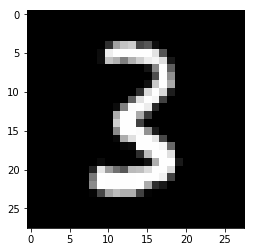

In [89]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [90]:
model,opt = get_model()

In [91]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [92]:
fit()

In [93]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0516, grad_fn=<NllLossBackward>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

#### Exercise 10
** Create a randomized index of the dataset inside the method `__iter__` **

In [95]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = None
        for i in range(0, self.n, self.bs): 
            pass

In [ ]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [ ]:
small_ds = Dataset(*train_ds[:10])

In [ ]:
s = Sampler(small_ds,3,False)
[o for o in s]

In [ ]:
s = Sampler(small_ds,3,True)
[o for o in s]

In [ ]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [ ]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

In [ ]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

### PyTorch DataLoader

In [ ]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [ ]:
xb,yb = next(iter(train_dl))

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

PyTorch's defaults work fine for most things however:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [ ]:
xb,yb = next(iter(train_dl))

In [ ]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

If the batch size varies, the loss and accuracy also varies so the validation results would be different.

`get_dls` returns dataloaders for the training and validation sets:

In [ ]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

In [ ]:
assert acc>0.9

## Export

In [ ]:
!python notebook2script.py 03_minibatch_training.ipynb